In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import random

In [20]:
import os 
import json

In [21]:
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

# RIDGE REGRESSION

We perform ridge regression due to multicolienarity in our data. We tune parameters by searching through parameter space and minimizing the log score of the model.

In [23]:
data = pd.read_excel("all_data/dummified.xlsx")
data.drop(columns=['Unnamed: 0'], inplace=True)
data.columns 

Index(['Defibrilacija 15 - 20 min', 'Starost bolnika ob srčnem zastoju',
       'Defibrilacija 10 - 15 min', 'Defibrilacija se ni zgodila',
       'Odzivni čas v sekundah - od časa sprejema klica do prihoda do pacienta',
       'Defibrilacija >= 20 min', 'Defibrilacija <= 10 min',
       'Terapevtska hipotermija (TTM, Targeted temperature management)_NEZNANO',
       'Terapevtska hipotermija (TTM, Targeted temperature management)_Po-ROSC, bolnišnično',
       'Terapevtska hipotermija (TTM, Targeted temperature management)_Po-ROSC, predbolnišnično',
       'Povrnitev spontanega krvnega obtoka (ROSC)_ROSC',
       'Odziv očividca (Utstein)_NEZNANO',
       'Odziv očividca (Utstein)_Samo stisi prsnega koša',
       'Odziv očividca (Utstein)_Stisi prsnega koša in umetno predihavanje',
       'Spol pacienta (Utstein)_Moški',
       'Začetni (prvi) ritem (Utstein)_AED - defibrilacija je potrebna (angl. schockable rhythm)',
       'Začetni (prvi) ritem (Utstein)_AED - defibrilacija ni potrebn

In [24]:
target_columns = ["Povrnitev spontanega krvnega obtoka (ROSC)_ROSC", "30-dnevno preživetje ali preživetje do odpusta_Da"]
X = data[list(filter(lambda x : x not in target_columns, data.columns))]

y1, y2 = data[target_columns[0]], data[target_columns[1]]

Columns to standardize are numerical values that need to be standardized before runnign the model. 

In [26]:
columns_to_standardize = ['Starost bolnika ob srčnem zastoju', 'Odzivni čas v sekundah - od časa sprejema klica do prihoda do pacienta']
column_to_imputate = 'Odzivni čas v sekundah - od časa sprejema klica do prihoda do pacienta'

In [36]:
parameter_space =  {    
    'imputation_method' : ['mean', 'median'],
    'penalty' : ['l2', 'l1'],
    'C' : np.logspace(-4, 1, 25),
    'solver' : ['lbfgs', 'liblinear'],
    'max_iter' : [10000]
    }

In [37]:
def standardize(X_train, X_test):
    """
    By standardizing the numeric input data, we ensure that each feature contributes equally to the model's predictions.
    """

    # združi X_train in X_test
    X_mean = np.mean(X_train, axis=0) # mean of columns
    X_std = np.std(X_train, axis=0)

    # use the same values on test data to use the same scaling as we did on train data!
    X_train, X_test = (X_train - X_mean) / X_std, (X_test - X_mean) / X_std

    return X_train, X_test


COLORS = [
    'b', 'g', 'r', 'c', 'm', 'y', 'k',         # Blue, Green, Red, Cyan, Magenta, Yellow, Black
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', # HTML Color Names
    '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 
    '#bcbd22', '#17becf', '#800080', '#008080'  # Purple, Teal
]

In [38]:
# data_ems["Odzivni čas v sekundah - od časa sprejema klica do prihoda do pacienta - mean"] = data_ems["Odzivni čas v sekundah - od časa sprejema klica do prihoda do pacienta"].fillna(mean)
# data_ems["Odzivni čas v sekundah - od časa sprejema klica do prihoda do pacienta - median"] = data_ems["Odzivni čas v sekundah - od časa sprejema klica do prihoda do pacienta"].fillna(median)

In [43]:
def imputation(X_train, X_test, imputation_method, column_to_imputate, method=None):
    """
    Imputate missing values - be careful to imputate the test set with the same imputation method/value as the train set.
    X_train and X_test are dataframes, X_test does not necessarily need imputation.
    """
    
    if imputation_method=='mean':
        mean = np.nanmean(X_train[column_to_imputate])
        X_train[column_to_imputate] = X_train[column_to_imputate].fillna(mean)
        X_test[column_to_imputate] = X_test[column_to_imputate].fillna(mean)
            

    elif imputation_method=='median':
        median = np.nanmedian(X_train[column_to_imputate])
        X_train[column_to_imputate] = X_train[column_to_imputate].fillna(median)
        X_test[column_to_imputate] = X_test[column_to_imputate].fillna(median)
        
    else:
        print("IMPUTATION METHOD NOT RECOGNIZED")


    # print(X_train.head())
    return X_train, X_test


In [44]:
def test_parameters(X, y, solver, penalty, lmbda, max_iter, columns_to_standardize, column_to_imputate=column_to_imputate, imputation_method='mean'):
    """
    Performs leave one out cross validation for a model with given lambda and computes log score and rmse for each fold which will help us evaluate the model. 
    """
    log_scores, accuracies = [], []
    
    for i in range(len(X)):
        
        X_train, X_test = X.loc[[j for j in range(len(X)) if j != i]] , X.loc[[i]]
        y_train, y_test = y.loc[[j for j in range(len(X)) if j != i]] , y.loc[[i]]

        X_train, X_test = imputation(X_train, X_test, imputation_method=imputation_method, column_to_imputate=column_to_imputate)
        
        X_train[columns_to_standardize], X_test[columns_to_standardize] = standardize(X_train[columns_to_standardize], X_test[columns_to_standardize])

        model = LogisticRegression(#multi_class='multinomial', 
                                    fit_intercept=True,
                                    solver=solver,
                                    penalty=penalty,
                                    C=lmbda,
                                    max_iter=max_iter)

        X_train, y_train = np.array(X_train.values.tolist()), np.array(y_train)
        
        X_test, y_test = np.array(X_test.values.tolist()), np.array(y_test)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)#[0]
        y_pred_proba = model.predict_proba(X_test)#[:,1]#[0]

        accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)
        log_score = log_loss(y_pred=y_pred_proba[:,1], y_true=y_test, labels=[0,1])

        log_scores.append(log_score)
        accuracies.append(accuracy)
    
    return log_scores, accuracies

In [45]:
def find_optimal_parameters(X, y, parameter_space, columns_to_standardize, column_to_imputate=column_to_imputate, imputation_method='mean'):
    """
    For different values of lambda penalization parameter we perform LOOCV and estimate the best value for the parameter. 
    """

    evaluation_results = dict()
    evaluation_results_plot = dict()

    counter = 0

    json_path = "results2/model_eval/log_reg/finding_optimal_parameters.json"

    fig, axs = plt.subplots(1, 2, figsize=(25, 10))
    plot_legend = []
    
    for penalty in parameter_space['penalty']:
        for solver in parameter_space['solver']:
            if (solver, penalty) in [('lbfgs', 'none'), ('lbfgs', 'l2'),  ('liblinear', 'l1'), ('liblinear', 'l2'), ('newton-cg', 'l2'), ('newton-cg', 'none'), ('newton-cholesky', 'none'), ('newton-cholesky', 'l2'), ('sag', 'l2'), ('sag', 'none'), ('saga', 'elasticnet'), ('saga', 'l1'), ('saga', 'l2'), ('saga', 'none')]:

                for max_iter in parameter_space['max_iter']:
                    print(f"Combination : {penalty}, {solver}, {max_iter}!")
                    best_score, best_lmbda = np.inf, None

                    # regularization_results_ll, regularization_results_acc = dict(), dict()
                    ll = []
                    acc = []

                    for lmbda in parameter_space['C']:
                        

                        # print(lmbda)
                        
                        log_scores, accuracies = test_parameters(X, y, solver, penalty, lmbda, max_iter, columns_to_standardize, column_to_imputate=column_to_imputate, imputation_method=imputation_method)

                        # regularization_results_ll[lmbda], regularization_results_acc[lmbda] = np.mean(log_scores), np.mean(accuracies)
                        ll.append(np.mean(log_scores))
                        acc.append(np.mean(accuracies))

                        # evaluation_results[(penalty, solver, max_iter, lmbda)] = (np.mean(log_scores), np.mean(accuracies), log_scores, accuracies)
                        
                        evaluation_results[counter] = {'penalty' : penalty, 'solver' : solver, 'max_iter' : max_iter, 'C' : lmbda, 'log_score' : np.mean(log_scores), 'accuracy' : np.mean(accuracies)}
                        
                        if np.mean(log_scores) <= best_score:
                            best_score = np.mean(log_scores)
                            best_lmbda = lmbda

                    print(f"For combination : {penalty}, {solver}, {max_iter} the best lambda was {best_lmbda} and mean log score was {best_score}")
                    
                    
                    axs[0].plot(parameter_space['C'], ll, color=COLORS[counter], label=solver + ', ' + penalty)
                    axs[1].plot(parameter_space['C'], acc, color=COLORS[counter], label=solver + ', ' + penalty)

                    plot_legend.append(solver + ', ' + penalty)
                    counter += 1

                    if os.path.exists(json_path):
                        os.remove(json_path)

                    with open(json_path, 'w') as json_file:
                        json.dump(evaluation_results, json_file)

    axs[0].set_title('Mean log score')
    axs[0].set_xlabel('Regularization parameter')
    axs[0].set_ylabel('Mean log score')
    axs[0].legend(plot_legend)

    axs[1].set_title('Mean accuracy')
    axs[1].set_xlabel('Regularization parameter')
    axs[1].set_ylabel('mean accuracy')
    axs[1].legend(plot_legend)

    return evaluation_results

Combination : l2, lbfgs, 10000!
For combination : l2, lbfgs, 10000 the best lambda was 0.1333521432163324 and mean log score was 0.5441612213407508
Combination : l2, liblinear, 10000!
For combination : l2, liblinear, 10000 the best lambda was 0.1333521432163324 and mean log score was 0.5476201417776172
Combination : l1, liblinear, 10000!
For combination : l1, liblinear, 10000 the best lambda was 0.3480700588428413 and mean log score was 0.5529439828708329
Combination : l2, lbfgs, 10000!
For combination : l2, lbfgs, 10000 the best lambda was 0.1333521432163324 and mean log score was 0.5435102600898174
Combination : l2, liblinear, 10000!
For combination : l2, liblinear, 10000 the best lambda was 0.1333521432163324 and mean log score was 0.5470645246259643
Combination : l1, liblinear, 10000!
For combination : l1, liblinear, 10000 the best lambda was 0.3480700588428413 and mean log score was 0.5518036922998265


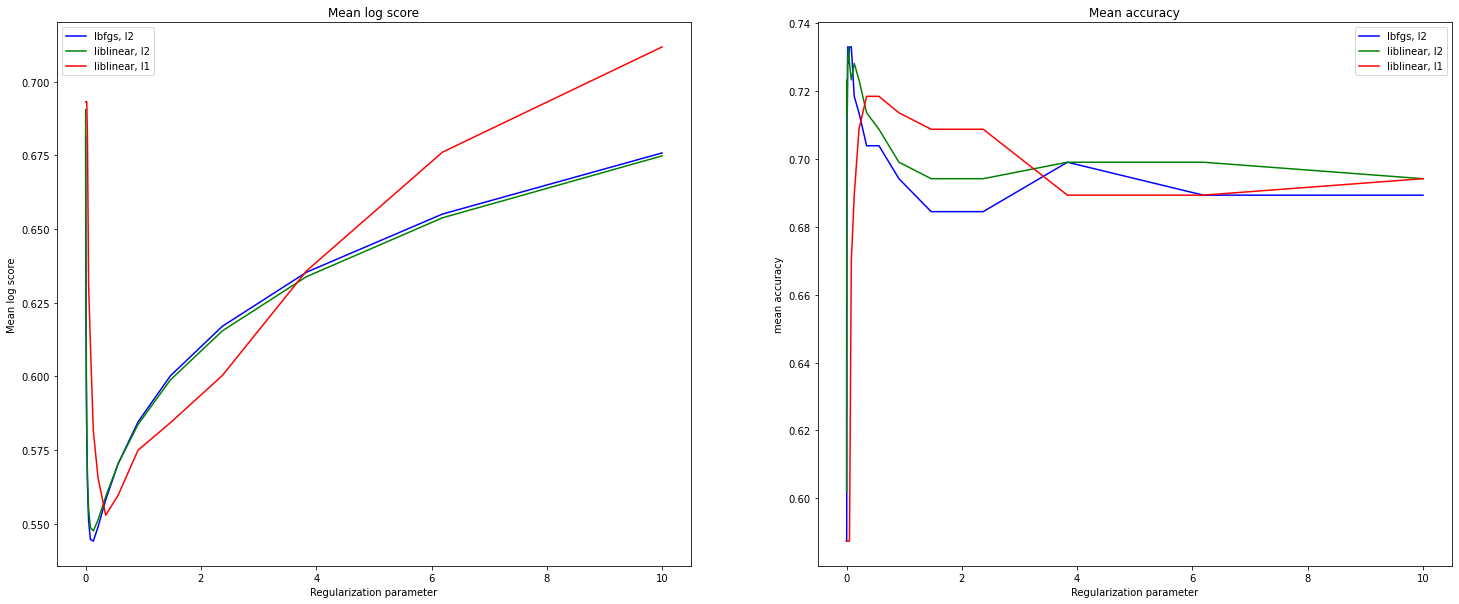

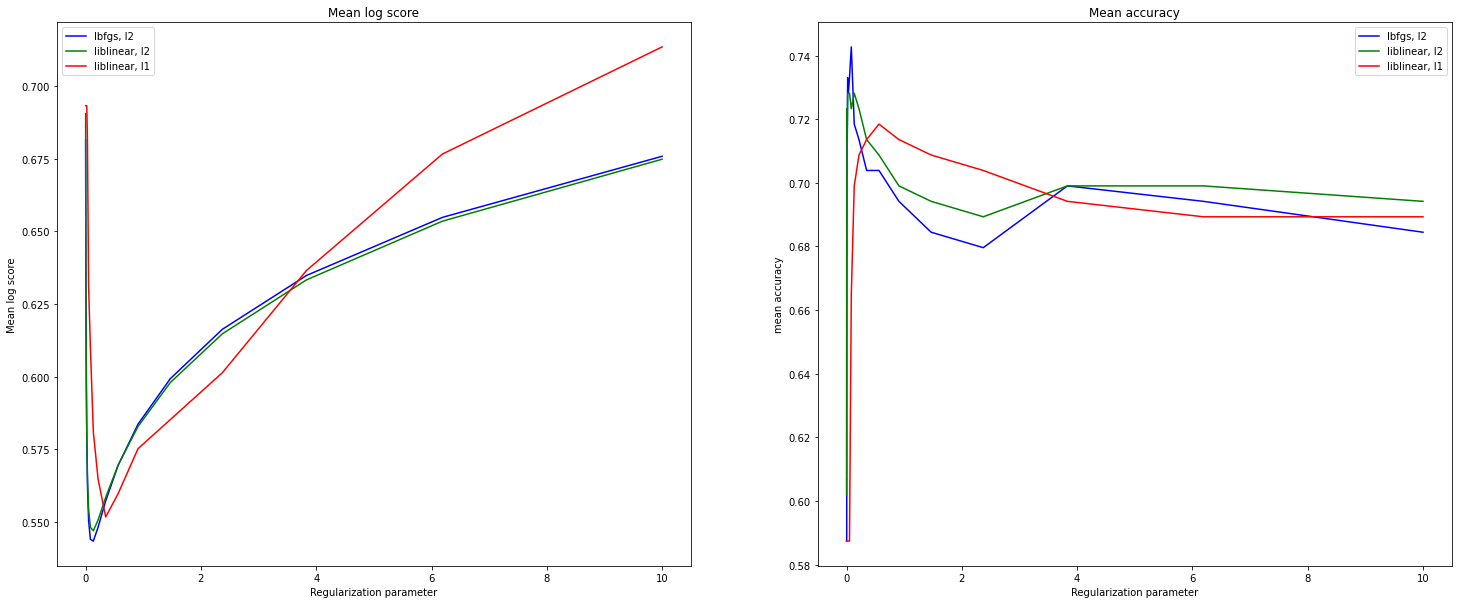

In [46]:
evaluation_results_mean = find_optimal_parameters(X, y1,parameter_space, columns_to_standardize, column_to_imputate=column_to_imputate, imputation_method='mean')
evaluation_results_median = find_optimal_parameters(X, y1, parameter_space, columns_to_standardize, column_to_imputate=column_to_imputate, imputation_method='median')

In [49]:
lambda1_l2 = 0.1333521432163324
lambda1_l1 = 0.3480700588428413

Combination : l2, lbfgs, 10000!
For combination : l2, lbfgs, 10000 the best lambda was 0.9085175756516871 and mean log score was 0.15575390519797636
Combination : l2, liblinear, 10000!
For combination : l2, liblinear, 10000 the best lambda was 0.9085175756516871 and mean log score was 0.15467162986371394
Combination : l1, liblinear, 10000!
For combination : l1, liblinear, 10000 the best lambda was 0.3480700588428413 and mean log score was 0.17786798280926872
Combination : l2, lbfgs, 10000!
For combination : l2, lbfgs, 10000 the best lambda was 0.9085175756516871 and mean log score was 0.15576282922433904
Combination : l2, liblinear, 10000!
For combination : l2, liblinear, 10000 the best lambda was 0.9085175756516871 and mean log score was 0.15465221004608753
Combination : l1, liblinear, 10000!


c:\Users\burge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


For combination : l1, liblinear, 10000 the best lambda was 0.3480700588428413 and mean log score was 0.17808389438404812


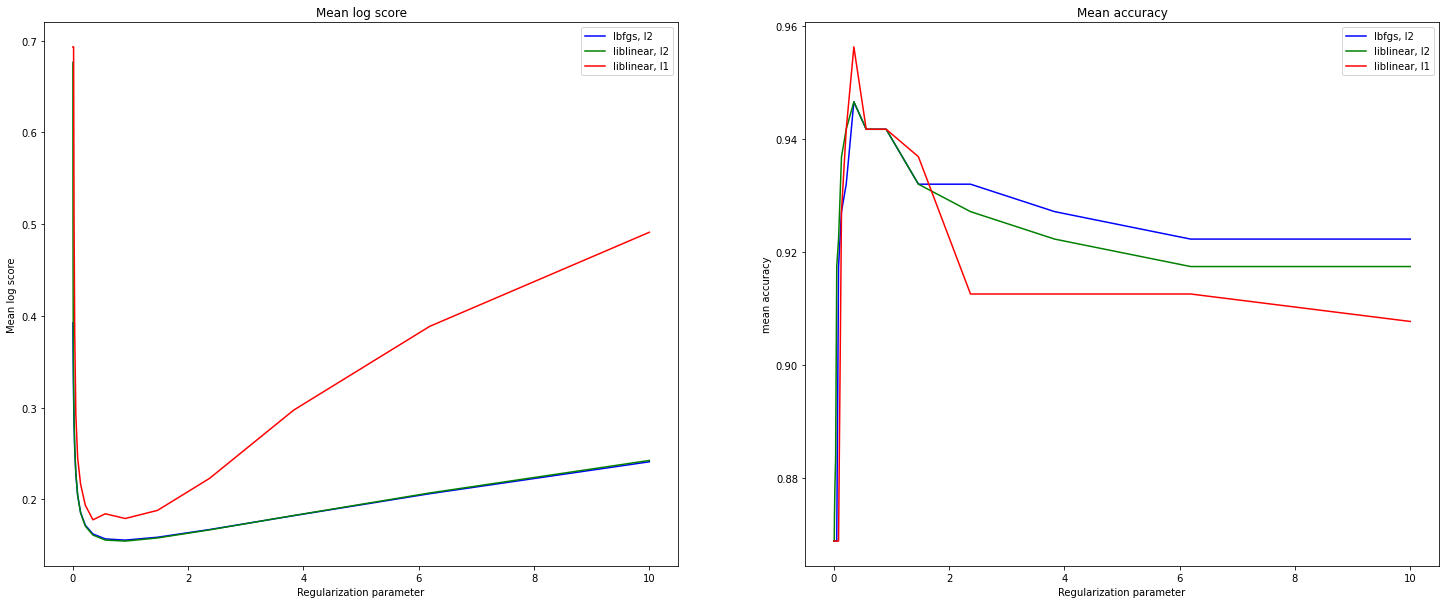

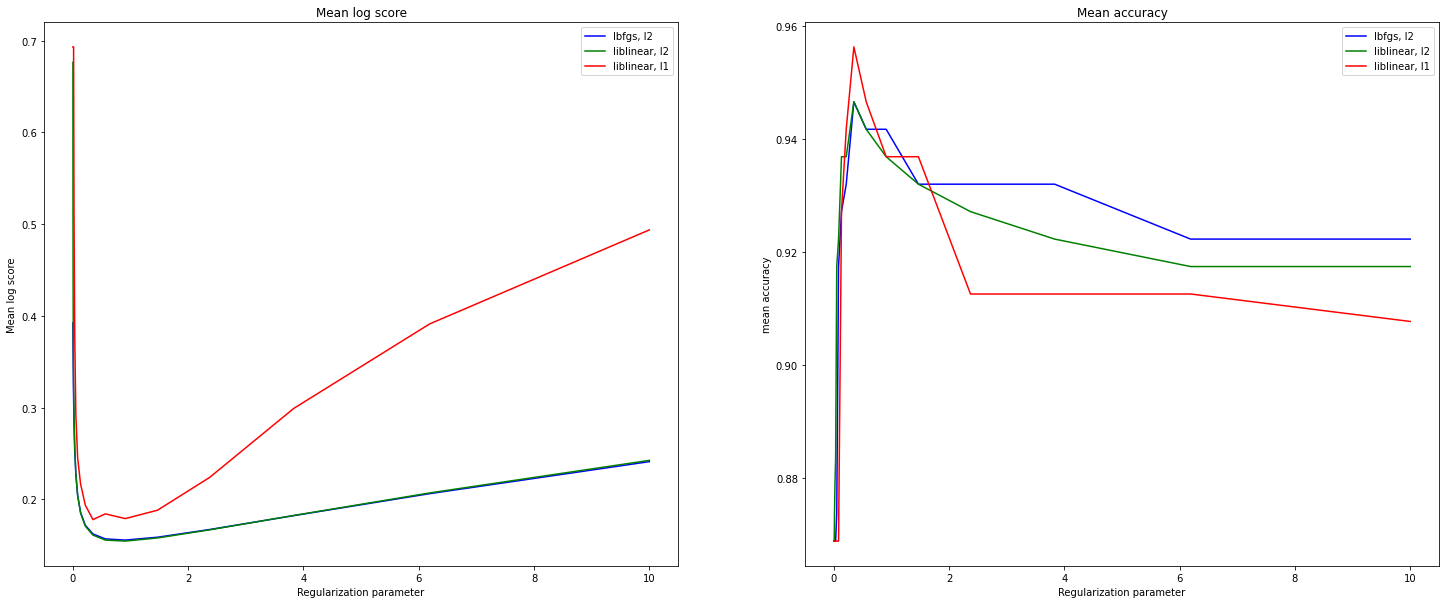

In [47]:
evaluation_results_mean = find_optimal_parameters(X, y2,parameter_space, columns_to_standardize, column_to_imputate=column_to_imputate, imputation_method='mean')
evaluation_results_median = find_optimal_parameters(X, y2, parameter_space, columns_to_standardize, column_to_imputate=column_to_imputate, imputation_method='median')

In [50]:
lambda2_l1, lambda2_l2 = 0.9085175756516871, 0.3480700588428413

In [48]:
def LOOCV(X, y, lmbda, solver, penalty, imputation_method='mean'):

    log_scores, accuracies = [], []
    models, model_coeffs = [], []

    
    for i in range(len(X)):
        
        X_train, X_test = X.loc[[j for j in range(len(X)) if j != i]] , X.loc[[i]]
        y_train, y_test = y.loc[[j for j in range(len(X)) if j != i]] , y.loc[[i]]

        X_train, X_test = imputation(X_train, X_test, imputation_method=imputation_method, column_to_imputate=column_to_imputate)
        
        X_train[columns_to_standardize], X_test[columns_to_standardize] = standardize(X_train[columns_to_standardize], X_test[columns_to_standardize])

        model = LogisticRegression(#multi_class='multinomial', 
                                    fit_intercept=True,
                                    solver=solver,
                                    penalty=penalty,
                                    C = lmbda,
                                    max_iter=10000)


        X_train, y_train = np.array(X_train.values.tolist()), np.array(y_train)
        
        X_test, y_test = np.array(X_test.values.tolist()), np.array(y_test)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)#[0]
        y_pred_proba = model.predict_proba(X_test)#[:,1]#[0]

        models.append(model)
        model_coeffs.append(model.coef_)

        accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)
        log_score = log_loss(y_pred=y_pred_proba[:,1], y_true=y_test, labels=[0,1])

        log_scores.append(log_score)
        accuracies.append(accuracy)

    return model_coeffs, log_scores, accuracies

In [51]:
model_coeffs, log_scores, accuracies = LOOCV(X, y1, lambda1_l2, solver='lbfgs', penalty='l2', imputation_method='median')

In [52]:
mean_coeffs = [np.mean([model_coeffs[i][0][j] for i in range(len(model_coeffs))]) for j in range(len(model_coeffs[0][0]))]
print(len(mean_coeffs))
print(len(X.columns))
# mean_coeffs
for i in range(len(X.columns)):
    print(f"{X.columns[i]} : {mean_coeffs[i]}")

48
48
Defibrilacija 15 - 20 min : 0.06809541536299615
Starost bolnika ob srčnem zastoju : -0.08313046287293212
Defibrilacija 10 - 15 min : 0.2404918450072889
Defibrilacija se ni zgodila : -0.4047869001168984
Odzivni čas v sekundah - od časa sprejema klica do prihoda do pacienta : -0.33507492259154814
Defibrilacija >= 20 min : 0.11189729072886936
Defibrilacija <= 10 min : 0.2404918450072889
Terapevtska hipotermija (TTM, Targeted temperature management)_NEZNANO : -0.5924573467226814
Terapevtska hipotermija (TTM, Targeted temperature management)_Po-ROSC, bolnišnično : 0.23323030743674752
Terapevtska hipotermija (TTM, Targeted temperature management)_Po-ROSC, predbolnišnično : 0.12563066811615423
Odziv očividca (Utstein)_NEZNANO : 0.06424459813798536
Odziv očividca (Utstein)_Samo stisi prsnega koša : -0.0577560933914491
Odziv očividca (Utstein)_Stisi prsnega koša in umetno predihavanje : -0.006997484980058845
Spol pacienta (Utstein)_Moški : -0.14463632189391779
Začetni (prvi) ritem (Utstei

In [59]:
def bootstrap(X, y, n, lmbda, solver, penalty, imputation_method, column_to_imputate=column_to_imputate):
    """
    For the regularization parameter we computed we perform bootstrap.
    We sample with replacement, compute coefficients and log score.
    """
    results = dict()
    for i in range(n):

        if i % 100 == 0:
            print(i)

        X['target_variable'] = y
        sample = X.sample(
                    frac=1, replace=True, random_state=random.randint(1, 1000000)
                    )
        
        y_sample = sample['target_variable']
        X_sample = sample[[col for col in X.columns if col != 'target_variable']]

        model = LogisticRegression(#multi_class='multinomial', 
                                    fit_intercept=True,
                                    solver=solver,
                                    penalty=penalty,
                                    C=lmbda,
                                    max_iter=10000)
        
        X_sample, X_sample = imputation(X_sample, X_sample, imputation_method=imputation_method, column_to_imputate=column_to_imputate)
        X_sample, y_sample = np.array(X_sample.values.tolist()), np.array(y_sample)
        
        
        model.fit(X_sample, y_sample)
    

        results[i] = model.coef_


    return results

In [60]:
results = bootstrap(X, y1, 1000, lambda1_l2, 'lbfgs', 'l2', imputation_method='median')

0


C:\Users\burge\AppData\Local\Temp\ipykernel_27980\1139402026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_variable'] = y
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column_to_imputate] = X_train[column_to_imputate].fillna(median)
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

100


C:\Users\burge\AppData\Local\Temp\ipykernel_27980\1139402026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_variable'] = y
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column_to_imputate] = X_train[column_to_imputate].fillna(median)
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

200


C:\Users\burge\AppData\Local\Temp\ipykernel_27980\1139402026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_variable'] = y
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column_to_imputate] = X_train[column_to_imputate].fillna(median)
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

300


C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[column_to_imputate] = X_test[column_to_imputate].fillna(median)
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\1139402026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_variable'] = y
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

400


C:\Users\burge\AppData\Local\Temp\ipykernel_27980\1139402026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_variable'] = y
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column_to_imputate] = X_train[column_to_imputate].fillna(median)
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

500


C:\Users\burge\AppData\Local\Temp\ipykernel_27980\1139402026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_variable'] = y
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column_to_imputate] = X_train[column_to_imputate].fillna(median)
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

600


C:\Users\burge\AppData\Local\Temp\ipykernel_27980\1139402026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_variable'] = y
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column_to_imputate] = X_train[column_to_imputate].fillna(median)
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

700


C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[column_to_imputate] = X_test[column_to_imputate].fillna(median)
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\1139402026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_variable'] = y
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

800


C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[column_to_imputate] = X_test[column_to_imputate].fillna(median)
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\1139402026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_variable'] = y
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

900


C:\Users\burge\AppData\Local\Temp\ipykernel_27980\1139402026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_variable'] = y
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column_to_imputate] = X_train[column_to_imputate].fillna(median)
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [64]:
def confidence(x):
    alpha = 0.05
    sd = np.std(x)
    n = len(x)-len(list(filter(lambda y : np.isnan(y), x)))
    z = 1.96
    bound = z*(sd / np.sqrt(n))
    # print(n, sd, bound)
    ci = [np.mean(x) - bound, np.mean(x), np.mean(x) + bound]
    return ci


In [65]:
new_results = [[results[j][0][i] for j in range(len(results))] for i in range(len(results[0][0]))]
len(new_results)

r = [confidence(new_results[i]) for i in range(len(new_results))]

sorted_lists = sorted(zip(r, list(X.columns)), key=lambda x: x[0][1])

# Unzip the sorted result back into separate lists
sorted_list_of_lists, sorted_list_of_strings = zip(*sorted_lists)

list_of_lists = []
for i in range(len(r)):
    print(sorted_list_of_strings[i])
    print(f"{round(sorted_list_of_lists[i][1], 2)} 95 % CI: {round(sorted_list_of_lists[i][0], 2)} to {round(sorted_list_of_lists[i][2], 2)}")
    list_of_lists.append([sorted_list_of_strings[i], round(sorted_list_of_lists[i][1], 2), round(sorted_list_of_lists[i][0], 2), round(sorted_list_of_lists[i][2], 2)])

Koronarna reperfuzija_NEZNANO
-0.8 95 % CI: -0.81 to -0.79
Terapevtska hipotermija (TTM, Targeted temperature management)_NEZNANO
-0.59 95 % CI: -0.6 to -0.58
Defibrilacija se ni zgodila
-0.41 95 % CI: -0.41 to -0.4
Dispečer je prepoznal prisotnost zastoja srca pred prihodom NMP_Da
-0.22 95 % CI: -0.23 to -0.21
Vzrok srčnega zastoja (Utstein)_NEZNANO
-0.18 95 % CI: -0.19 to -0.17
Začetni (prvi) ritem (Utstein)_PEA
-0.15 95 % CI: -0.16 to -0.14
Spol pacienta (Utstein)_Moški
-0.15 95 % CI: -0.16 to -0.14
Zdravila uporabljena med oživljanjem_Adrenalin
-0.13 95 % CI: -0.14 to -0.12
Uporaba AED s strani očividca_AED uporabljen, defibrilacija ni izvedena
-0.1 95 % CI: -0.11 to -0.09
Odziv očividca (Utstein)_Samo stisi prsnega koša
-0.06 95 % CI: -0.07 to -0.05
Kraj/mesto/lokacija srčnega zastoja (Utstein)_Delovno mesto
-0.06 95 % CI: -0.06 to -0.06
Ali se je srčni zastoj zgodil vpričo očividcev? (Utstein)_NEZNANO
-0.04 95 % CI: -0.04 to -0.04
Ali pokriva DCZ?_Da
-0.04 95 % CI: -0.05 to -0.03

In [66]:
cols = ['variable', 'mean', 'lower_bound', 'upper_bound']

df = pd.DataFrame(list_of_lists, columns=cols)
df.to_excel("results_20240106/rosc_coeffs.xlsx")

In [68]:
old_df = df
df = df[~df['variable'].str.contains('NEZNANO')]

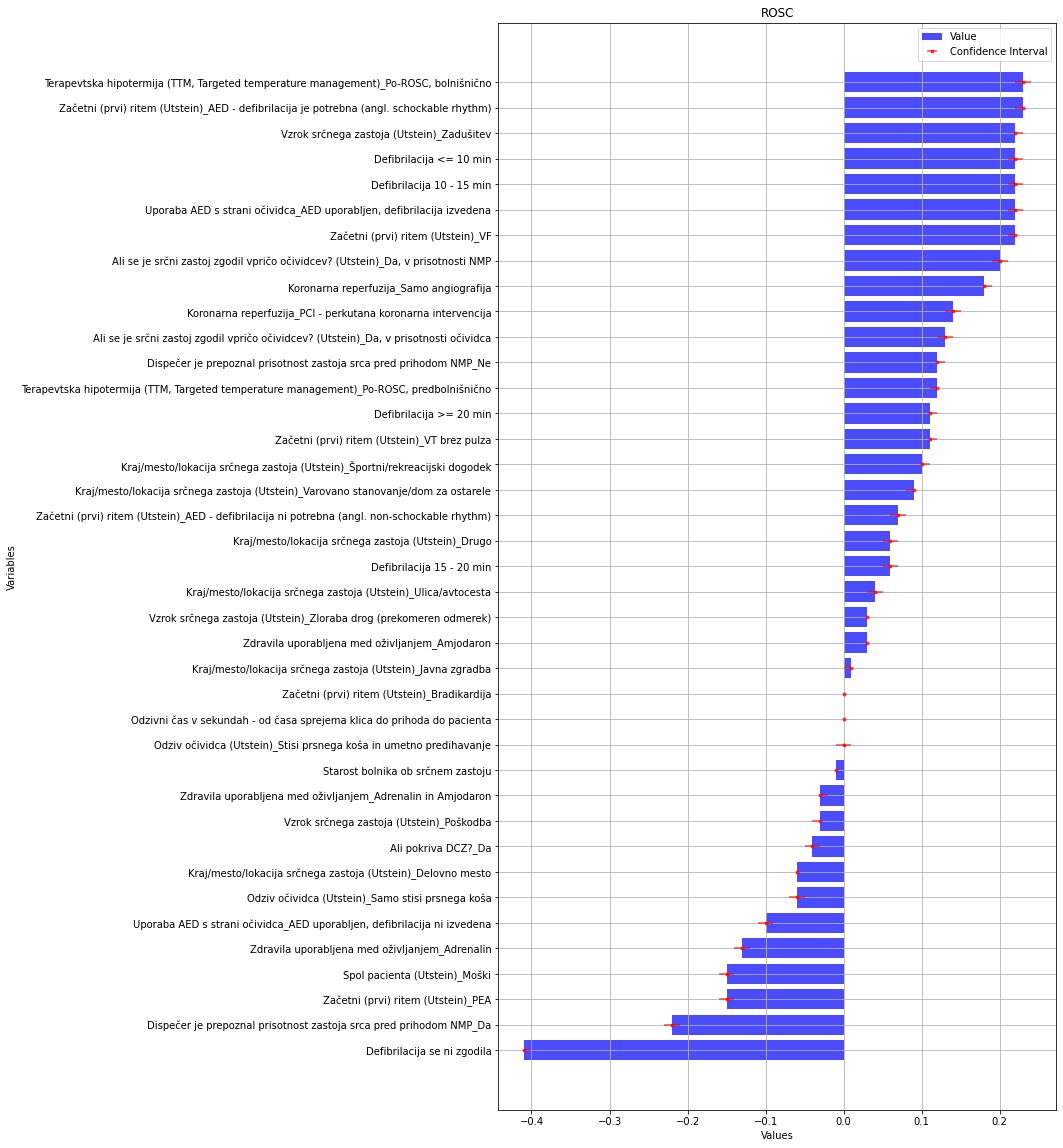

In [70]:
plt.figure(figsize=(10, 20))
plt.barh(df['variable'], df['mean'], color='blue', alpha=0.7, label='Value')

# Plot horizontal error bars for confidence intervals
plt.errorbar(df['mean'], df['variable'],
             xerr=[df['mean'] - df['lower_bound'], df['upper_bound'] - df['mean']],
             fmt='.', color='red', alpha=0.7, label='Confidence Interval')



# Customize the plot
plt.xlabel('Values')
plt.ylabel('Variables')
plt.title('ROSC')
plt.legend()
plt.grid(True)
plt.savefig("ROSC")
plt.show()

In [71]:

model_coeffs, log_scores, accuracies = LOOCV(X, y2, lambda2_l2, solver='lbfgs', penalty='l2', imputation_method='median')

In [72]:
mean_coeffs = [np.mean([model_coeffs[i][0][j] for i in range(len(model_coeffs))]) for j in range(len(model_coeffs[0][0]))]
print(len(mean_coeffs))
print(len(X.columns))
# mean_coeffs
for i in range(len(X.columns)):
    print(f"{X.columns[i]} : {mean_coeffs[i]}")

49
49
Defibrilacija 15 - 20 min : 0.660428462688107
Starost bolnika ob srčnem zastoju : -0.42470711825025764
Defibrilacija 10 - 15 min : 0.09666696766249716
Defibrilacija se ni zgodila : -0.6423406186833988
Odzivni čas v sekundah - od časa sprejema klica do prihoda do pacienta : -0.18622807680930678
Defibrilacija >= 20 min : 0.11317406913760239
Defibrilacija <= 10 min : 0.09666696766249716
Terapevtska hipotermija (TTM, Targeted temperature management)_NEZNANO : -1.0510062645929452
Terapevtska hipotermija (TTM, Targeted temperature management)_Po-ROSC, bolnišnično : 0.13647034460730847
Terapevtska hipotermija (TTM, Targeted temperature management)_Po-ROSC, predbolnišnično : 0.24492743286163904
Odziv očividca (Utstein)_NEZNANO : 0.37133489780296536
Odziv očividca (Utstein)_Samo stisi prsnega koša : 0.2186914611881861
Odziv očividca (Utstein)_Stisi prsnega koša in umetno predihavanje : -0.27782994219417795
Spol pacienta (Utstein)_Moški : 0.34591549599392135
Začetni (prvi) ritem (Utstein)_

In [74]:
results = bootstrap(X, y2, 1000, lambda2_l2, 'lbfgs', 'l2', imputation_method='median')

0


C:\Users\burge\AppData\Local\Temp\ipykernel_27980\1139402026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_variable'] = y
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column_to_imputate] = X_train[column_to_imputate].fillna(median)
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

100


C:\Users\burge\AppData\Local\Temp\ipykernel_27980\1139402026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_variable'] = y
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column_to_imputate] = X_train[column_to_imputate].fillna(median)
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

200


C:\Users\burge\AppData\Local\Temp\ipykernel_27980\1139402026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_variable'] = y
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column_to_imputate] = X_train[column_to_imputate].fillna(median)
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

300


C:\Users\burge\AppData\Local\Temp\ipykernel_27980\1139402026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_variable'] = y
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column_to_imputate] = X_train[column_to_imputate].fillna(median)
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

400


C:\Users\burge\AppData\Local\Temp\ipykernel_27980\1139402026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_variable'] = y
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column_to_imputate] = X_train[column_to_imputate].fillna(median)
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

500


C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[column_to_imputate] = X_test[column_to_imputate].fillna(median)
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\1139402026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_variable'] = y
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

600


C:\Users\burge\AppData\Local\Temp\ipykernel_27980\1139402026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_variable'] = y
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column_to_imputate] = X_train[column_to_imputate].fillna(median)
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

700


C:\Users\burge\AppData\Local\Temp\ipykernel_27980\1139402026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_variable'] = y
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column_to_imputate] = X_train[column_to_imputate].fillna(median)
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

800


C:\Users\burge\AppData\Local\Temp\ipykernel_27980\1139402026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_variable'] = y
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column_to_imputate] = X_train[column_to_imputate].fillna(median)
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

900


C:\Users\burge\AppData\Local\Temp\ipykernel_27980\1139402026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_variable'] = y
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column_to_imputate] = X_train[column_to_imputate].fillna(median)
C:\Users\burge\AppData\Local\Temp\ipykernel_27980\152423868.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [75]:
new_results = [[results[j][0][i] for j in range(len(results))] for i in range(len(results[0][0]))]
len(new_results)

r = [confidence(new_results[i]) for i in range(len(new_results))]

sorted_lists = sorted(zip(r, list(X.columns)), key=lambda x: x[0][1])

# Unzip the sorted result back into separate lists
sorted_list_of_lists, sorted_list_of_strings = zip(*sorted_lists)

list_of_lists = []
for i in range(len(r)):
    print(sorted_list_of_strings[i])
    print(f"{round(sorted_list_of_lists[i][1], 2)} 95 % CI: {round(sorted_list_of_lists[i][0], 2)} to {round(sorted_list_of_lists[i][2], 2)}")
    list_of_lists.append([sorted_list_of_strings[i], round(sorted_list_of_lists[i][1], 2), round(sorted_list_of_lists[i][0], 2), round(sorted_list_of_lists[i][2], 2)])

Terapevtska hipotermija (TTM, Targeted temperature management)_NEZNANO
-1.1 95 % CI: -1.11 to -1.09
Koronarna reperfuzija_NEZNANO
-0.74 95 % CI: -0.75 to -0.73
Zdravila uporabljena med oživljanjem_Adrenalin
-0.68 95 % CI: -0.69 to -0.67
Defibrilacija se ni zgodila
-0.68 95 % CI: -0.68 to -0.67
Kraj/mesto/lokacija srčnega zastoja (Utstein)_Ulica/avtocesta
-0.5 95 % CI: -0.51 to -0.49
Začetni (prvi) ritem (Utstein)_PEA
-0.32 95 % CI: -0.33 to -0.32
Zdravila uporabljena med oživljanjem_Adrenalin in Amjodaron
-0.23 95 % CI: -0.24 to -0.21
Odziv očividca (Utstein)_Stisi prsnega koša in umetno predihavanje
-0.21 95 % CI: -0.22 to -0.2
Vzrok srčnega zastoja (Utstein)_NEZNANO
-0.2 95 % CI: -0.21 to -0.19
Vzrok srčnega zastoja (Utstein)_Poškodba
-0.2 95 % CI: -0.2 to -0.19
Dispečer je prepoznal prisotnost zastoja srca pred prihodom NMP_Da
-0.16 95 % CI: -0.16 to -0.15
Začetni (prvi) ritem (Utstein)_AED - defibrilacija ni potrebna (angl. non-schockable rhythm)
-0.14 95 % CI: -0.14 to -0.14
Upora

In [76]:
cols = ['variable', 'mean', 'lower_bound', 'upper_bound']

df = pd.DataFrame(list_of_lists, columns=cols)
df.to_excel("results_20240106/30d_coeffs.xlsx")

In [77]:
old_df = df
df = df[~df['variable'].str.contains('NEZNANO')]

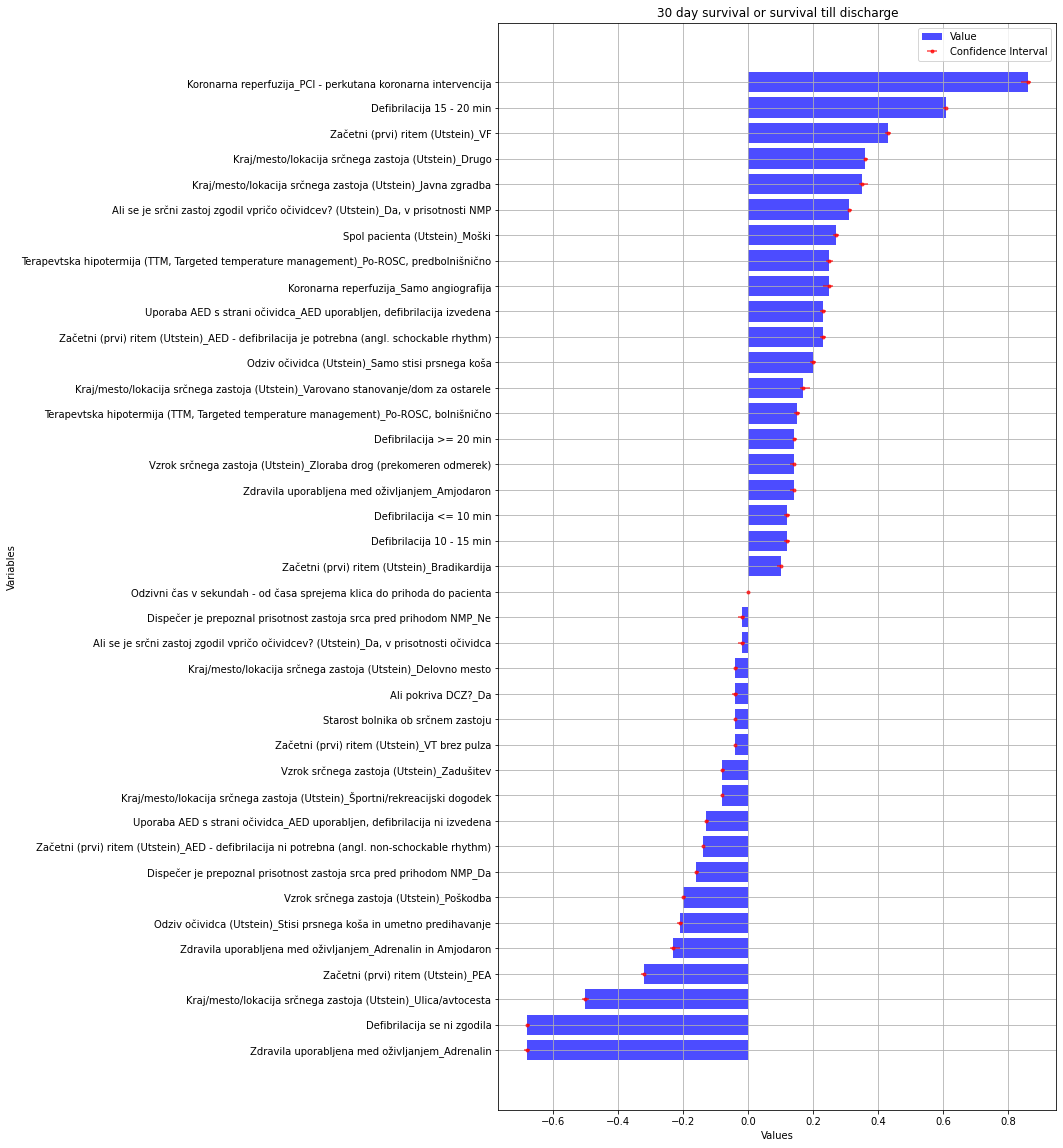

In [78]:
plt.figure(figsize=(10, 20))
plt.barh(df['variable'], df['mean'], color='blue', alpha=0.7, label='Value')

# Plot horizontal error bars for confidence intervals
plt.errorbar(df['mean'], df['variable'],
             xerr=[df['mean'] - df['lower_bound'], df['upper_bound'] - df['mean']],
             fmt='.', color='red', alpha=0.7, label='Confidence Interval')



# Customize the plot
plt.xlabel('Values')
plt.ylabel('Variables')
plt.title('30 day survival or survival till discharge')
plt.legend()
plt.grid(True)
plt.savefig("30 day survival or survival till discharge")
plt.show()